# Projet STT 3795 - Système de recommandation
Equipe : Lylian Challier, Danil Garmaev, Lilian Strub

## Importation des librairies

In [1]:
# on a des data_set de base et de test mais là je vais commencer avec le gros data_set pour trouver quoi faire
# on verra ensuite pour des essaies en base et tester avec les tests

import numpy as np
import pandas as pd
import seaborn as sns
import re

from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer 

from surprise import SVD 
from surprise import Dataset
from surprise import Reader 
from surprise.model_selection import cross_validate


## Compréhension du DataSet MovieLens100k

Dans un premier temps, nous allons importer nos données et afficher les tables de données.  
Ainsi nous allons nous familiariser avec les attributs et le types de données à notre disposition pour le projet.

In [2]:
# les notes des films par les utilisateurs
data = pd.read_csv("ml-100k/u.data", sep=None ,names=['userid', 'movieid', 'rating', 'timestamp'])
data.head(5)
#data.describe()
# les notes des films sont entre 1 et 5 la moyenne à 3.53/5
# il a 943 users
# et 1682 films notés

/tmp/ipykernel_3843/466328612.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv("/home/jovyan/Projet Data Science/ml-100k/u.data", sep=None ,names=['userid', 'movieid', 'rating', 'timestamp'])


,userid,movieid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
# les informations sur les films : titre, date, genres
# liste des 17 genres
genre = pd.read_csv("ml-100k/u.genre", sep='|', names=['genre', 'genreid'])['genre'].values
print(genre)
attribut_item = ['movieid', 'title', 'date','video_date', 'imdb_url']+list(genre)

item = pd.read_csv("ml-100k/u.item", encoding='latin1', sep='|', names=attribut_item)
print(item[list(genre)].sum())
item.head(5)

#item.describe()
# il y a des NaN dans toute la colonne video_date
# tous les genres sont représentés au moins une fois
# mais les genres les plus représentés sont Drama, Comedy, Action et Thriller
# on a bien les 1682 films comme dans data



['unknown' 'Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']
unknown          2
Action         251
Adventure      135
Animation       42
Children's     122
Comedy         505
Crime          109
Documentary     50
Drama          725
Fantasy         22
Film-Noir       24
Horror          92
Musical         56
Mystery         61
Romance        247
Sci-Fi         101
Thriller       251
War             71
Western         27
dtype: int64


,movieid,title,date,video_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# les informations sur les personnes interrogées : age, genre, métier, code postale 
# (US je pense car le dataset vient de l'Université du Minnesota)
# liste des 21 occupations
occupation = pd.read_csv("ml-100k/u.occupation", header=None).values # vecteur contenant les occupations
# print(len(occupation))

user = pd.read_csv("ml-100k/u.user", sep='|', names=['userid', 'age', 'gender', 'occupation', 'zipcode'])
user.head(5)
# essayer de se servir de l'age pour recommandation ou genre ou type d'emploi ???

,userid,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


## Nettoyage et pré-traitement des données

Dans cette partie, nous allons trier les informations et garder celles qui nous intéressent pour notre système de recommandations.  
Aussi, nous allons ajouter de nouvelles caractéristiques utiles à notre projet.

In [5]:
# Création d'une nouvelle table de données à partir de data et de item
movie_data = pd.merge(data[['userid', 'movieid', 'rating']], item[['movieid', 'title']+list(genre)], on='movieid').sort_values('movieid')
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head(5)
movie_data[['title', 'userid', 'rating']+list(genre)].head(5)

movie_data.head()


,userid,movieid,rating,title,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
3732,805,1,4,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3759,124,1,3,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3760,882,1,5,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3761,779,1,4,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3762,542,1,4,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Créer une nouvelle table avec les genres, notes moyennes et nombre de notes selon les titres de films 
item_rating_genre = pd.DataFrame()
item_rating_genre['title'] = pd.DataFrame(movie_data.groupby('movieid')['title'].max())
item_rating_genre['rating_mean'] = pd.DataFrame(movie_data.groupby('movieid')['rating'].mean())
item_rating_genre['rating_counts'] = pd.DataFrame(movie_data.groupby('movieid')['rating'].count())
item_rating_genre[list(genre)] = pd.DataFrame(movie_data.groupby('movieid')[list(genre)].mean()) # moyenne de 0 et de 1 conserve la structure des genres
#item_rating_genre['title'] = pd.DataFrame(movie_data.groupby('movieid')['title'].max())
# on est revenu là, après l'algorithme pour ajouter le movieid
#item_rating_genre['movieid'] = pd.DataFrame(movie_data.groupby('movieid')['movieid'].max()) # max du même movieid conserve le bon movieid

#item_rating_genre['title'] = item_rating_genre.index
#item_rating_genre.index = ((range(len(item_rating_genre))))
item_rating_genre = item_rating_genre.sort_values('movieid')

item_rating_genre.head(5)


,title,rating_mean,rating_counts,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),3.878319,452,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GoldenEye (1995),3.206107,131,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Four Rooms (1995),3.033333,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Get Shorty (1995),3.550239,209,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Copycat (1995),3.302326,86,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Analyse exploratoire des données (EDA) 

Dans cette partie nous allons analyser les données, observer leur distribution et les effets de corrélations.  
Ceci dans le but de déterminer si les informations sont importantes et pour prévenir les biais des valeurs aberrantes.

Text(0.5, 1.0, 'Distribution du nombre de notes par films')

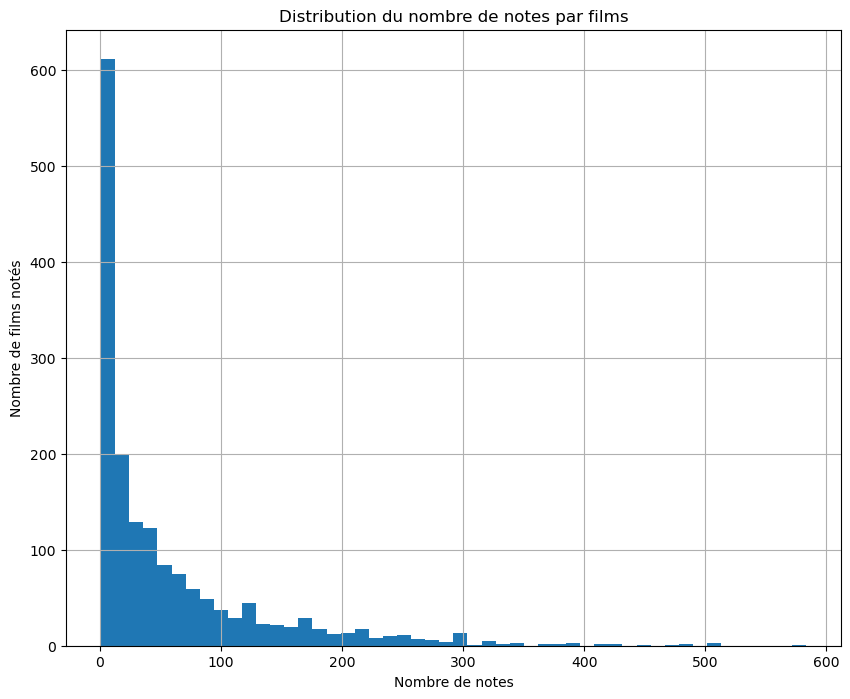

In [7]:
# On remarque que beacoup de films ont reçus très peu de notes
# Il est donc important de prendre en compte la différence entre le nombre de notes reçues
plt.figure(figsize=(10,8))
item_rating_genre['rating_counts'].hist(bins=50)
plt.xlabel('Nombre de notes')
plt.ylabel('Nombre de films notés')
plt.title('Distribution du nombre de notes par films')
#plt.savefig('distrib_nb_notes.png')

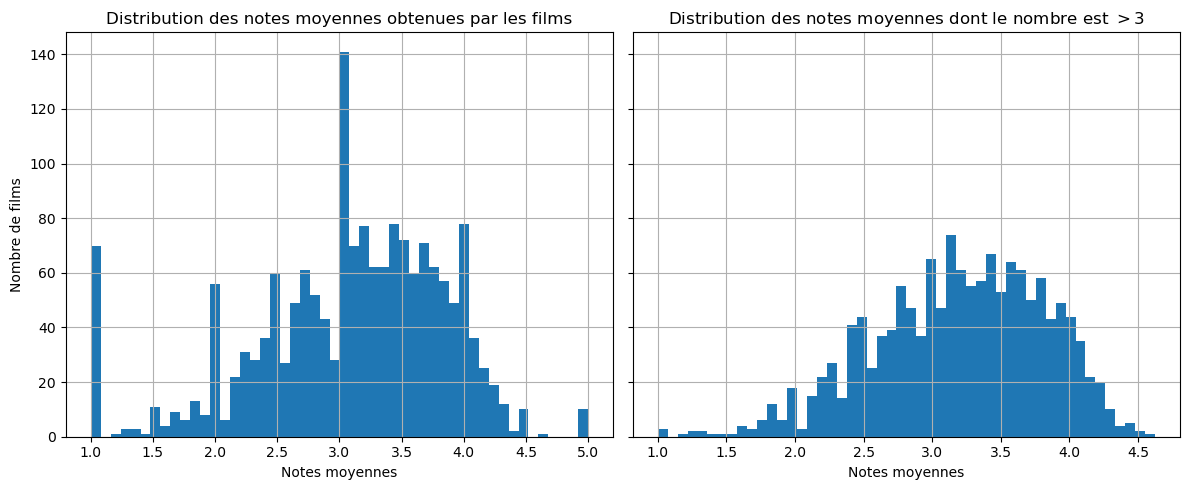

In [8]:
# Ici on observe la distribution des notes moyennes des films
# on remarque une distribution plus ou moins normale centrée sur 3.5
# Mais on surtout qu'il y a beaucoup de notes sur les valeurs entières 1, 2, 3, 4, 5
# cela doit venir des films peu noté qui restent donc avec une moyenne entière
k = 3 # rien qu'en supprimant les notes moyennes basées sur 3 notes et moins on voit que cet effet est limité
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
item_rating_genre['rating_mean'].hist(bins=50,ax=ax[0])
item_rating_genre[item_rating_genre.loc[:, 'rating_counts'] > k]['rating_mean'].hist(bins=50, ax=ax[1])
ax[0].set_xlabel('Notes moyennes')
ax[0].set_ylabel('Nombre de films')
ax[0].set_title('Distribution des notes moyennes obtenues par les films')
ax[1].set_xlabel('Notes moyennes')
ax[1].set_title(f'Distribution des notes moyennes dont le nombre est $>{k}$')

plt.tight_layout()
#plt.savefig('distrib_notes_moy.png')

<Figure size 1000x800 with 0 Axes>

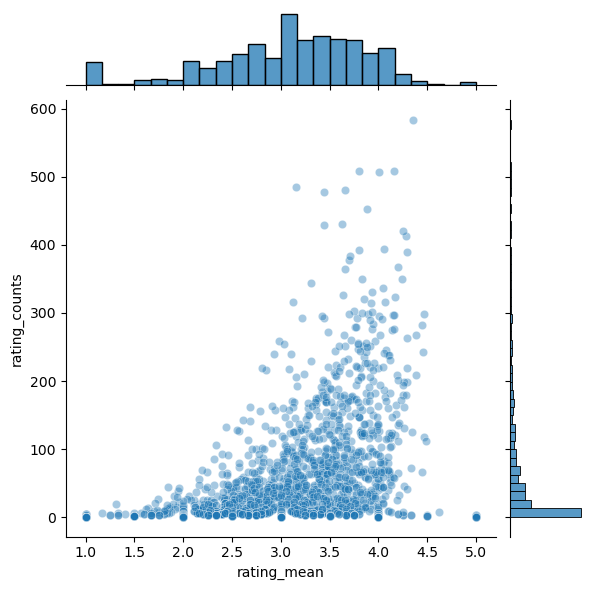

In [9]:
# Avec ce graphique, on remarque que les films avec beaucoup de notes, sont plutôt bien notés
# Et aussi qu'on a une niche de films avec une notes de 5/5 qui ont très peu de notes
# En revenant aux deux graphiques précédents, on remarque que ces films sont présents à gauche, pile sur la note de 5/5
# mais pas à droite, cela veut dire que ces films comptent 3 avis ou moins, il faudra s'en méfier ce sont des valeurs aberrantes 
plt.figure(figsize=(10,8))
sns.jointplot(x='rating_mean', y='rating_counts', data=item_rating_genre, alpha=0.4)
#plt.savefig('jointplot.png')

## Mise en place de l'algorithme

Dans cette partie, nous allons faire un choix d'algorithme à appliquer sur nos données.

### Filtrage basé sur le contenu

Dans cette sous-partie, nous allons utiliser le filtrage basé sur le contenu.  
Cela consiste à recommander aux utilisateurs un ou des films selon la similarité qu'ils ont avec des films déjà aimés par l'utilisateur.  
  
Pour mettre en place ce filtrage, nous allons utiliser la table de données 'item_rating_genre' pour dresser une matrice de similarité entre les films.  
Nous utiliserons la similarité cosinus et nous allons nous servire des notes moyennes et du nombre de notes pour pondérer cette similarité.  
Cela nous permettra de mettre plus en avant des films populaires et bien notés afin de plaire au mieux à l'utilisateur.

In [10]:
# on utilisera cette table de données
item_rating_genre[list(genre)].head(5)

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# on créée la matrice des genres que l'on pondère avec la fréquence inverse des films de chaque genres
# on avait des soucis sans cette pondération 
mat_genre = np.array((item_rating_genre[list(genre)] * (1 - item_rating_genre[list(genre)].sum()/len(item_rating_genre))))
print(mat_genre[:4, :4])

# on utilise la similitude cosinus sur notre matrice
genre_similarities = cosine_similarity(mat_genre, mat_genre)
print(genre_similarities[:4, :4])


[[0.         0.         0.         0.97502973]
 [0.         0.85077289 0.91973841 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.85077289 0.         0.        ]]
[[1.         0.         0.         0.26038733]
 [0.         1.         0.56177156 0.38548521]
 [0.         0.56177156 1.         0.        ]
 [0.26038733 0.38548521 0.         1.        ]]


In [12]:
# on définit une fonction qui prend en entrée le nom d'un film et qui renvoie n recommandations
def content_based(film, n, data=item_rating_genre) : 

    if film not in data['title'].values : 
        raise ValueError("Ce film n'est pas dans notre jeu de données")

    movie_id = data.loc[data['title']==film].index[0] # trouve l'id du film et index = id-1


    # on pondère avec la note moyenne
    rating_mean = (data['rating_mean'].values) # vecteur des notes moyennes 
    mat_rating_mean = np.tile(rating_mean, (len(list(genre)), 1)).T


    # filtre nombre de notes minimales
    rating_counts =  ((data['rating_counts'].values))  # malus
    mat_rating_counts = np.tile(rating_counts, (len(list(genre)), 1)).T

    # filtre les films avec moins de 50 avis, cela causait du bruit
    filtered_counts = np.array(data['rating_counts']>50)*1
    mat_filter = np.tile(filtered_counts, (len(rating_counts), 1))


    # on créée la matrice des genres que l'on pondère avec la fréquence inverse des films de chaque genres
    # et on pondère avec la note moyenne des films et le nombre de notes
    mat_genre = np.array((data[list(genre)] *( ( 1- data[list(genre)].sum()/len(item_rating_genre)))) * mat_rating_mean * (1-mat_rating_counts) )
    
    # on utilise la similitude cosinus sur notre matrice
    genre_similarities = cosine_similarity(mat_genre) * np.ones((1682, 1682)) * mat_filter
    
    # liste des similitude du film en question
    movie_similarities = list(enumerate(genre_similarities[movie_id-1]))
    
    # trie cette liste selon le score de similitude
    sorted_movies = sorted(movie_similarities, key = lambda x : x[1], reverse=True) 

    top_movies = []
    for i in range(1, n+1) : 
        #print(sorted_movies[i])
        t = [data.index[sorted_movies[i][0]], data.loc[data.index==sorted_movies[i][0]+1]['title'].values[0]]
        top_movies.append(t)

    return pd.DataFrame(top_movies, columns=['movieid', 'title'])

print(content_based('Aladdin (1992)', 16))

    movieid                                   title
0        71                   Lion King, The (1994)
1        99  Snow White and the Seven Dwarfs (1937)
2       418                       Cinderella (1950)
3       432                         Fantasia (1940)
4       501                            Dumbo (1941)
5       538                        Anastasia (1997)
6       588             Beauty and the Beast (1991)
7       596     Hunchback of Notre Dame, The (1996)
8       420              Alice in Wonderland (1951)
9       473        James and the Giant Peach (1996)
10      993                         Hercules (1997)
11        1                        Toy Story (1995)
12       91  Nightmare Before Christmas, The (1993)
13      419                     Mary Poppins (1964)
14      542                       Pocahontas (1995)
15      102                  Aristocats, The (1970)


In [13]:
# reeherche films par noms pour voir leur attributs
#item_rating_genre.loc[item_rating_genre['title'] == 'American President, The (1995)'].iloc[0]

### Filtrage collaboratif

Dans cette sous-partie, nous allons utiliser le filtrage collaboratif.  
Cela consiste à regrouper des utilisateurs qui se ressemblent dans la manière de noter les films qu'ils ont vus.  
Ainsi lorsqu'un des utilisateurs a bien aimé un film qu'un utilisateur similaire n'a pas vu, on peut le lui recommander.  
  
Pour mettre en place ce filtarge, nous allons utiliser la méthode de la factorisation matricielle SVD .  
Cela nous permettra de prévoir les notes que les utilisateurs pourraient mettre aux films qu'ils n'ont pas encore vus.  
Ainsi on pourra recommandé à l'utilisateur le films qu'il est le plus probable d'aimé/de bien noté.

In [15]:
user_ratings = data
print(user_ratings)

       userid  movieid  rating  timestamp
0         196      242       3  881250949
1         186      302       3  891717742
2          22      377       1  878887116
3         244       51       2  880606923
4         166      346       1  886397596
...       ...      ...     ...        ...
99995     880      476       3  880175444
99996     716      204       5  879795543
99997     276     1090       1  874795795
99998      13      225       2  882399156
99999      12      203       3  879959583

[100000 rows x 4 columns]


In [16]:
movie_metadata = item
genres = movie_metadata[list(genre)[1:]]
movie_metadata['genres']= movie_metadata.apply(lambda row: {col: row[col] for col in genres.columns}, axis =1)
movie_metadata = movie_metadata[['movieid', 'title','genres']]

# On supprime les doublons et créer un DataFrame contenant uniquement les colonnes 'movieid' et 'title'
unique_movies = movie_data[['movieid', 'title']].drop_duplicates()
year_movie_dict = unique_movies.set_index('movieid')['title'].to_dict()

movie_metadata.head()

,movieid,title,genres
0,1,Toy Story (1995),"{'Action': 0, 'Adventure': 0, 'Animation': 1, ..."
1,2,GoldenEye (1995),"{'Action': 1, 'Adventure': 1, 'Animation': 0, ..."
2,3,Four Rooms (1995),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
3,4,Get Shorty (1995),"{'Action': 1, 'Adventure': 0, 'Animation': 0, ..."
4,5,Copycat (1995),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."


In [17]:
year_movie_dict

{1: 'Toy Story (1995)',
 2: 'GoldenEye (1995)',
 3: 'Four Rooms (1995)',
 4: 'Get Shorty (1995)',
 5: 'Copycat (1995)',
 6: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 7: 'Twelve Monkeys (1995)',
 8: 'Babe (1995)',
 9: 'Dead Man Walking (1995)',
 10: 'Richard III (1995)',
 11: 'Seven (Se7en) (1995)',
 12: 'Usual Suspects, The (1995)',
 13: 'Mighty Aphrodite (1995)',
 14: 'Postino, Il (1994)',
 15: "Mr. Holland's Opus (1995)",
 16: 'French Twist (Gazon maudit) (1995)',
 17: 'From Dusk Till Dawn (1996)',
 18: 'White Balloon, The (1995)',
 19: "Antonia's Line (1995)",
 20: 'Angels and Insects (1995)',
 21: 'Muppet Treasure Island (1996)',
 22: 'Braveheart (1995)',
 23: 'Taxi Driver (1976)',
 24: 'Rumble in the Bronx (1995)',
 25: 'Birdcage, The (1996)',
 26: 'Brothers McMullen, The (1995)',
 27: 'Bad Boys (1995)',
 28: 'Apollo 13 (1995)',
 29: 'Batman Forever (1995)',
 30: 'Belle de jour (1967)',
 31: 'Crimson Tide (1995)',
 32: 'Crumb (1994)',
 33: 'Desperado (1995)',
 34: '

In [18]:
movie_data = user_ratings.merge(movie_metadata, on='movieid')

def remove_year(title):
    return re.sub(r'\s*\(\d{4}\)', '', title)

movie_data['title'] = movie_data['title'].apply(remove_year)
movie_data['title'] = movie_data['title'].str.strip()

movie_data.head()

,userid,movieid,rating,timestamp,title,genres
0,196,242,3,881250949,Kolya,"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
1,63,242,3,875747190,Kolya,"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
2,226,242,5,883888671,Kolya,"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
3,154,242,3,879138235,Kolya,"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
4,306,242,5,876503793,Kolya,"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."


On utilise les dictionnaires avec les noms des films et leur titres pour faciliter le travail 

In [19]:
unique_movies = movie_data[['movieid', 'title']].drop_duplicates()

# On crée un dictionnaire à partir du DataFrame unique_movies avec 'movieid' comme clé et 'title' comme valeur
movie_dict = unique_movies.set_index('movieid')['title'].to_dict()

# On crée un dictionnaire inverse pour avoir 'title' comme clé et 'movieid' comme valeur
inverse_movie_dict = unique_movies.set_index('title')['movieid'].to_dict()
inverse_movie_dict

{'Kolya': 242,
 'L.A. Confidential': 302,
 'Heavyweights': 377,
 'Legends of the Fall': 51,
 'Jackie Brown': 346,
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb': 474,
 'Hunt for Red October, The': 265,
 'Jungle Book, The': 465,
 'Grease': 451,
 'Remains of the Day, The': 86,
 'Men in Black': 257,
 "Romy and Michele's High School Reunion": 1014,
 'Star Trek: First Contact': 222,
 'To Wong Foo, Thanks for Everything! Julie Newmar': 40,
 'Batman Forever': 29,
 'Only You': 785,
 'Age of Innocence, The': 387,
 'Sabrina': 486,
 'Just Cause': 1042,
 'Endless Summer 2, The': 1184,
 'Man Without a Face, The': 392,
 'Die Hard': 144,
 'Twister': 118,
 'Toy Story': 1,
 'Broken Arrow': 546,
 'Aladdin': 95,
 'Casper': 768,
 'Restoration': 277,
 'Jaws': 234,
 'Chasing Amy': 268,
 'Silence of the Lambs, The': 98,
 'Right Stuff, The': 193,
 'Sleepless in Seattle': 88,
 'Sting, The': 194,
 'Curdled': 1081,
 'Rear Window': 603,
 'Speechless': 796,
 'Crumb': 32,
 'French Twist (Ga

In [94]:
def find_movie(s): 
    return inverse_movie_dict[s]

On crée maintenant une matrice user-item qui a les identifiants des films sur les colonnes et les identifiants des utilisateurs sur les lignes. Chaque cellule de cette matrice montre si l'utilisatuer a aimé un film particulier. Si l'uilisateur n'a pas regardé le film, alors la cellule contient 0.

In [20]:
user_item_matrix = movie_data.pivot(index = 'movieid', columns = 'userid', values = 'rating').fillna(0)
user_item_matrix

userid,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movieid,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Maintenant nous allons utiliser un algorithme pour le collaborative filtering, le KNN semble un choix optimale pour faire la tache. C'est un algorithme qui n'a pas besoin d'entrainement, cependant il faut faire attention au choix de paramètres.

In [21]:
#on prend la similarité cosinus comme métrique
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)

#on fit le modèle sur notre matrice
model_knn.fit(user_item_matrix.values)
distances, indices = model_knn.kneighbors(user_item_matrix.values, n_neighbors = 5)

Le tableau `indices` est un tableau 2-dimensionnel qui contient pour chaque film les films les plus similaires. Le premier élément de chaque ligne est en général le filme lui-même. On ajoute 1 car les identifiants des films commencent par 1 et non par 0.

In [22]:
indices +=1
indices

array([[   1,   50,  181,  121,  117],
       [   2,  233,  161,  385,  403],
       [   3,  410,  763,   42,   33],
       ...,
       [1679, 1680, 1678, 1395, 1431],
       [1681, 1672, 1351, 1622, 1423],
       [1682,  767, 1335, 1597,  593]])

Le tableau `distances` contient donc les distances entre les films - plus le nombre est petit, plus il y a de similarités.

In [23]:
distances

array([[0.        , 0.26542794, 0.30007503, 0.3102144 , 0.33544521],
       [0.        , 0.34038138, 0.37645642, 0.38272632, 0.38385688],
       [0.        , 0.54797709, 0.55564493, 0.57675065, 0.59506968],
       ...,
       [0.        , 0.        , 0.        , 0.39697731, 0.51132222],
       [0.        , 0.29289322, 0.46547752, 0.56356422, 0.58297117],
       [0.        , 0.52190856, 0.57600085, 0.58791831, 0.67120203]])

#### Algorithme KNN (tentative échoué, bonne méthode plus bas)

On fait un exemple de prédiction sur le film **Jaws**. 

In [24]:
# le movie_id 'Jaws'
movie_id = inverse_movie_dict['Jaws']

# on trouve les indices des films 
sim_movies = indices[movie_id-1].tolist()
movie_distances = distances[movie_id-1].tolist()

sim_movies.remove(movie_id)
movie_distances.pop(0)

sim_movies = [movie_dict[i] for i in sim_movies]
print('The Nearest Movies to Jaws:', sim_movies)
print('The Distance from Jaws:', movie_distances)

The Nearest Movies to Jaws: ['Silence of the Lambs, The', 'Raiders of the Lost Ark', 'Alien', 'Fugitive, The']
The Distance from Jaws: [0.2949750513732974, 0.3310576855973417, 0.3324318746523752, 0.3345996827457439]


Maintenant on teste en utilisant l'algorithme KNN. On fera attention au choix de paramètres. Nous avons pris la similarité cosinus comme métrique en raison de son invariance à l'échelle et efficacité computationnelle. 

In [25]:
sim_movies = []
user_id = 6
umatrix_copy = user_item_matrix.copy()

n = 5
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_matrix.values)
distances, indices = knn.kneighbors(user_item_matrix.values, n_neighbors=n)


In [26]:
def recommend_movies(user, num_recommended_movies):

    print(f'La liste des films {user} a regardé \n')

    for m in user_item_matrix[user_item_matrix[user] > 0][user].index.tolist():
        print(m)

    print('\n')

    recommended_movies = []

    for m in user_item_matrix[user_item_matrix[user] == 0].index.tolist():

        index_df = user_item_matrix.index.tolist().index(m)
        predicted_rating = umatrix_copy.iloc[index_df, umatrix_copy.columns.tolist().index(user)]
        recommended_movies.append((m, predicted_rating))

    sorted_rm = sorted(recommended_movies, key=lambda x:x[1], reverse=True)

    print('Les films recommandés \n')
    rank = 1
    for recommended_movie in sorted_rm[:num_recommended_movies]:

        print('{}: {} - note prédite:{}'.format(rank, movie_dict[recommended_movie[0]], recommended_movie[1]))
        rank = rank + 1

In [27]:
user = 4
user_item_matrix[user_item_matrix[user]>0][user].index.tolist()

[11,
 50,
 210,
 258,
 260,
 264,
 271,
 288,
 294,
 300,
 301,
 303,
 324,
 327,
 328,
 329,
 354,
 356,
 357,
 358,
 359,
 360,
 361,
 362]

In [28]:
def movie_recommender(user, n, num_recommendation):
    """ 
        Fonction qui renvoie des recommandations de films pour un utilisateur donné.

    Args:
        user (int): Identifiant de l'utilisateur pour lequel on souhaite obtenir des recommandations.
        n (int): Nombre de voisins à considérer pour la recommandation.
        num_recommendation (int): Nombre de recommandations à renvoyer.

    Returns:
        pandas.DataFrame: Un DataFrame contenant les recommandations de films pour l'utilisateur spécifié.
    """
    
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(user_item_matrix.values)
    distances, indices = knn.kneighbors(user_item_matrix.values, n_neighbors=n)

    user_index = user_item_matrix.columns.tolist().index(user_id)

    for m,t in list(enumerate(user_item_matrix.index)):
        if user_item_matrix.iloc[m, user_index] == 0:
            sim_movies = indices[m-1].tolist()
            movie_distances = distances[m-1].tolist()

            if m in sim_movies:
                sim_movies.remove(m)
                movie_distances.pop(0) 

            movie_similarity = [1-x for x in movie_distances]
            movie_similarity_copy = movie_similarity.copy()
            summ = 0

            for s in range(0, len(movie_similarity)):
                if user_item_matrix.iloc[sim_movies[s], user_index] == 0:

                    if len(movie_similarity_copy) == (n - 1):
                        movie_similarity_copy.pop(s)

                    else:
                        movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))

                else:
                    summ += movie_similarity[s]*user_item_matrix.iloc[sim_movies[s],user_index]

            if len(movie_similarity_copy) > 0:

                if sum(movie_similarity_copy) > 0:
                    predicted_r = summ/sum(movie_similarity_copy)

                else:
                    predicted_r = 0

            else:
                predicted_r = 0

            umatrix_copy.iloc[m,user_index] = predicted_r
    recommend_movies(user, num_recommendation)

In [3]:
#movie_recommender(32,10,4)

#### Algorithme SVD (Matrix decomposition) (bonne méthode)
Ensuite on peut définir une fonction qui nous donnera les films recommandés

In [ ]:
# reader = Reader(rating_scale = (0.5,5))
# data = Dataset.load_from_df(movie_data[['userid', 'movieid', 'rating']], reader)

In [30]:
# algo = SVD()


In [31]:
# # Obtenir toutes les combinaisons utilisateur-film possibles
# all_user_ids = movie_data['userid'].unique()
# all_movie_ids = movie_data['movieid'].unique()

# # Prédire les notes pour chaque combinaison utilisateur-film
# predicted_ratings = []
# for user_id in all_user_ids:
#     for movie_id in all_movie_ids:
#         predicted_rating = algo.predict(user_id, movie_id)
#         predicted_ratings.append((user_id, movie_id, predicted_rating.est))

# # Convertir les prédictions en DataFrame pandas si nécessaire
# predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=['userid', 'movieid', 'predicted_rating'])


In [32]:
#predicted_ratings_df

In [33]:
# predicted_ratings_df = user_item_matrix.copy()

# # On remplace les valeurs manquantes par des prédictions du modèle SVD
# for user_id in user_item_matrix.index:
#     for movie_id in user_item_matrix.columns:
#         true_rating = user_item_matrix.loc[user_id, movie_id]
#         if true_rating == 0:
#             predicted_rating = algo.predict(user_id, movie_id).est
#             predicted_ratings_df.loc[user_id, movie_id] = predicted_rating

# predicted_ratings_df

#### L'implémentation de la méthode 

On peut également analyser les données et appliquer une méthode qui ne requiert pas l'utilisation d'algorithmes d'apprentissage automatique. 

Supposons un utilisateur a aimé un film et lui a mis une bonne note. Alors on récupère l'identifiant de ce film et on trouve des utilisateurs qui ont aussi bien noté ce film.

In [34]:
movie_id = 340

sim_users = user_ratings[(user_ratings['movieid'] == movie_id) & (user_ratings['rating'] >=4 )]['userid'].unique()
sim_users

array([261,  10, 204,  47, 111, 269,  58, 288, 201, 147, 107,   9, 350,
       276, 385, 192, 315, 284, 428, 229, 287, 239,  54, 128, 294, 383,
       250, 303, 327, 425, 126, 157, 491, 551, 353, 450, 448, 365,  64,
       489, 569, 179, 412, 174, 146, 119, 191, 423, 478, 605, 301, 443,
       634, 445, 669, 184, 587,  74,  90, 711, 547, 286, 628, 687, 752,
       429, 177, 220, 833, 436, 717,  79, 831, 683, 519, 555, 890, 699,
       414, 392, 828, 556, 540, 819, 936, 149, 592, 324, 645, 240, 176,
       710, 611, 926, 851, 740, 809, 657, 808, 335, 803, 894, 668, 537,
       842, 608, 673,   3, 920, 923, 919, 511, 695, 318])

Ensuite on trouve tous les films que les utilisateurs similaires ont bien noté et on normalise par rapport au nombre de notes qu'ils ont mis. 

In [35]:
sim_user_recs = user_ratings[(user_ratings["userid"].isin(sim_users)) & (user_ratings["rating"] >= 4)]["movieid"]

sim_user_recs

11       1014
20        392
31         98
35        274
40         16
         ... 
99925     251
99940     346
99957     474
99963     199
99968     287
Name: movieid, Length: 7692, dtype: int64

In [36]:
sim_user_recs = sim_user_recs.value_counts() / len(sim_users)
sim_user_recs

movieid
340     1.000000
302     0.517544
286     0.500000
313     0.482456
269     0.473684
          ...   
679     0.008772
637     0.008772
601     0.008772
1602    0.008772
399     0.008772
Name: count, Length: 1049, dtype: float64

On prends en compte des films qui ont généralement beaucoup de notes.

In [37]:
sim_user_recs = sim_user_recs[sim_user_recs > .15]
sim_user_recs

movieid
340    1.000000
302    0.517544
286    0.500000
313    0.482456
269    0.473684
         ...   
515    0.157895
69     0.157895
433    0.157895
93     0.157895
203    0.157895
Name: count, Length: 109, dtype: float64

Maintenant on cherche les notes de tous les utilisateurs qui ont noté les films similaires à notre. 

In [38]:
all_users = user_ratings[(user_ratings["movieid"].isin(sim_user_recs.index)) & (user_ratings["rating"] >= 4)]
all_user_recs = all_users["movieid"].value_counts() / len(all_users["userid"].unique())
all_user_recs

movieid
50     0.531847
100    0.430998
181    0.402335
127    0.372611
174    0.369427
         ...   
319    0.079618
331    0.062633
321    0.060510
305    0.059448
262    0.046709
Name: count, Length: 109, dtype: float64

On réunit les informations dans un dataframe

In [39]:
rec_percentages = pd.concat([sim_user_recs, all_user_recs], axis=1)
rec_percentages.columns = ["similar", "all"]
rec_percentages

,similar,all
movieid,,
340,1.000000,0.121019
302,0.517544,0.253715
286,0.500000,0.316348
313,0.482456,0.301486
269,0.473684,0.235669
...,...,...
515,0.157895,0.178344
69,0.157895,0.238854
433,0.157895,0.109342


Il suffit maintenant de calculer le ratio pour chaque film, trier par rapport à ce ratio et prendre les meilleurs films. Ce sont les films recommandés.

In [40]:
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
rec_percentages = rec_percentages.sort_values("score", ascending=False)
rec_percentages.head(10).merge(movie_metadata, left_index=True, right_on="movieid")[["movieid","score", "title", "genres"]]

,movieid,score,title,genres
339,340,8.263158,Boogie Nights (1997),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
304,305,3.836466,"Ice Storm, The (1997)","{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
261,262,3.755981,In the Company of Men (1997),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
345,346,3.541353,Jackie Brown (1997),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
346,347,2.754386,Wag the Dog (1997),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
320,321,2.609418,Mother (1996),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
330,331,2.520963,"Edge, The (1997)","{'Action': 0, 'Adventure': 1, 'Animation': 0, ..."
302,303,2.413956,Ulee's Gold (1997),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
314,315,2.313684,Apt Pupil (1998),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
269,270,2.301133,Gattaca (1997),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."


Maintenant on regroupe tout ceci dans une fonction:

In [41]:
algo = SVD()
reader = Reader(rating_scale = (0.5,5))
data = Dataset.load_from_df(movie_data[['userid', 'movieid', 'rating']], reader)
trainset = data.build_full_trainset()
algo.fit(trainset)

In [42]:
def filtrage_collaboratif(user_id, movie_id, algo = algo, include_self = False):
    """ 
        Fonction qui trouve le
    """
    sim_users = user_ratings[(user_ratings['movieid'] == movie_id) & (user_ratings['rating'] >=4 )]['userid'].unique()
    sim_user_recs = user_ratings[(user_ratings["userid"].isin(sim_users)) & (user_ratings["rating"] >= 4)]["movieid"]
    sim_user_recs = sim_user_recs.value_counts() / len(sim_users)
    sim_user_recs = sim_user_recs[sim_user_recs > .15]
    
    all_users = user_ratings[(user_ratings["movieid"].isin(sim_user_recs.index)) & (user_ratings["rating"] >= 4)]
    all_user_recs = all_users["movieid"].value_counts() / len(all_users["userid"].unique())

    rec_percentages = pd.concat([sim_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]
    
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False)
    
    
    # Prédiction des notes pour chaque film
    predicted_ratings = {}
    for mov_id in user_item_matrix.columns:
        if mov_id in rec_percentages.index:
            if user_item_matrix.loc[user_id, mov_id] == 0: 
                predicted_rating = algo.predict(user_id, mov_id).est
                predicted_ratings[mov_id] = predicted_rating
    
    # Trie des films recommandés en fonction des scores
    recommended_movies = pd.DataFrame(predicted_ratings.items(), columns=['movieid', 'predicted_rating'])
    recommended_movies = recommended_movies.sort_values("predicted_rating", ascending=False)
    
    
    mov = rec_percentages.merge(movie_metadata, left_index=True, right_on="movieid")
    # Fusion des métadonnées des films recommandés
    recommended_movies = recommended_movies.merge(mov, on="movieid")[["movieid", "predicted_rating", "score", "title", "genres"]]
    recommended_movies = recommended_movies.sort_values("score", ascending = False)
    
    print(f"Recommended movies for user {user_id} who liked {movie_dict[movie_id]}")
    if not include_self:
        recommended_movies = recommended_movies.drop(recommended_movies.index[0])
    
    return recommended_movies.head(10)
    


In [43]:
filtrage_collaboratif(25,inverse_movie_dict['Alice in Wonderland'])

Recommended movies for user 25 who liked Alice in Wonderland


,movieid,predicted_rating,score,title,genres
192,404,3.467519,8.289195,Pinocchio (1940),"{'Action': 0, 'Adventure': 0, 'Animation': 1, ..."
203,142,3.272919,7.825000,Bedknobs and Broomsticks (1971),"{'Action': 0, 'Adventure': 1, 'Animation': 0, ..."
142,465,3.762782,6.659574,"Jungle Book, The (1994)","{'Action': 0, 'Adventure': 1, 'Animation': 0, ..."
66,686,4.023705,6.287946,"Perfect World, A (1993)","{'Action': 1, 'Adventure': 0, 'Animation': 0, ..."
196,627,3.412534,5.679435,Robin Hood: Prince of Thieves (1991),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
163,559,3.701108,5.589286,Interview with the Vampire (1994),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
187,160,3.556085,5.517628,Glengarry Glen Ross (1992),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
141,418,3.762833,5.465993,Cinderella (1950),"{'Action': 0, 'Adventure': 0, 'Animation': 1, ..."
96,419,3.889318,5.384174,Mary Poppins (1964),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
122,506,3.830667,5.216667,Rebel Without a Cause (1955),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."


In [44]:
filtrage_collaboratif(125,inverse_movie_dict['Batman'])

Recommended movies for user 125 who liked Batman


,movieid,predicted_rating,score,title,genres
180,231,2.967225,6.542354,Batman Returns (1992),"{'Action': 1, 'Adventure': 1, 'Animation': 0, ..."
89,232,3.764634,5.468841,Young Guns (1988),"{'Action': 1, 'Adventure': 0, 'Animation': 0, ..."
82,686,3.779000,5.312588,"Perfect World, A (1993)","{'Action': 1, 'Adventure': 0, 'Animation': 0, ..."
151,399,3.311694,5.276693,"Three Musketeers, The (1993)","{'Action': 1, 'Adventure': 1, 'Animation': 0, ..."
124,578,3.552543,5.071107,Demolition Man (1993),"{'Action': 1, 'Adventure': 0, 'Animation': 0, ..."
74,226,3.849016,4.777640,Die Hard 2 (1990),"{'Action': 1, 'Adventure': 0, 'Animation': 0, ..."
169,217,3.082075,4.545215,Bram Stoker's Dracula (1992),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
193,679,2.742931,4.515700,Conan the Barbarian (1981),"{'Action': 1, 'Adventure': 1, 'Animation': 0, ..."
165,49,3.137571,4.507651,I.Q. (1994),"{'Action': 0, 'Adventure': 0, 'Animation': 0, ..."
141,233,3.380749,4.488221,Under Siege (1992),"{'Action': 1, 'Adventure': 0, 'Animation': 0, ..."


#### Evaluation du modèle

On évalue notre modèle avec la cross-validation, et concernant l'erreur on utilise la norme l2 et l1.

In [45]:
cross_validate(algo, data, measures =['RMSE', 'MAE'], cv= 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9388  0.9382  0.9331  0.9384  0.9255  0.9348  0.0051  
MAE (testset)     0.7401  0.7398  0.7345  0.7382  0.7296  0.7364  0.0040  
Fit time          1.05    1.05    0.96    1.02    0.95    1.00    0.04    
Test time         0.11    0.11    0.32    0.11    0.11    0.15    0.08    


{'test_rmse': array([0.93876025, 0.93824503, 0.93308452, 0.93836464, 0.92547365]),
 'test_mae': array([0.74009476, 0.73982044, 0.73446692, 0.73815828, 0.72955387]),
 'fit_time': (1.0507264137268066,
  1.0491230487823486,
  0.9551217555999756,
  1.0184886455535889,
  0.9494338035583496),
 'test_time': (0.1111900806427002,
  0.10977959632873535,
  0.3158738613128662,
  0.10903644561767578,
  0.10917448997497559)}

### Méthode hybride

In [1]:
# movies = pd.read_csv("/Users/lilian/Documents/Ecole/MIASHS/s6/STT 3795 - Fond. théo. en sc. des données/Netflix-Recommendation-System/ml-100k/u.item", encoding='latin1', sep='|', names=attribut_item)
# movies

In [63]:
# def clean_title(title):
#     return re.sub("[^a-zA-Z0-9 ]", "", title)

In [2]:
# movies["clean_title"] = movies["title"].apply(clean_title)

In [ ]:
# movies

In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2))

# tfidf = vectorizer.fit_transform(movies["clean_title"])

In [ ]:
# title = "Toy Story"
# title = clean_title(title)
# query_vec = vectorizer.transform([title])
# similarity = cosine_similarity(query_vec, tfidf).flatten()
# indices = np.argpartition(similarity, -5)[-5:]
# results = movies.iloc[indices][::-1]    

In [ ]:
# results

In [ ]:
# ratings_data = pd.read_csv('/Users/lilian/Documents/Ecole/MIASHS/s6/STT 3795 - Fond. théo. en sc. des données/Netflix-Recommendation-System/archive-2/rating.csv')
# movies_data = pd.read_csv('/Users/lilian/Documents/Ecole/MIASHS/s6/STT 3795 - Fond. théo. en sc. des données/Netflix-Recommendation-System/archive-2/movie.csv')

# movie_ratings_data = pd.merge(ratings_data, movies_data, on='movieId')

In [ ]:
# # On crée un objet TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# # On construit la matrice TF-IDF à partir de la colonne 'genres'
# tfidf_matrix = tfidf_vectorizer.fit_transform(movies_data['genres'])

# # On vérifie la taille de la matrice
# print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

In [96]:
# Define a function to get top n recommended movies for a user bases on Hybrid Filtering
def get_hybrid_recommendations(user_id, nom_du_film, n=10):
    """
        
    """
    # On obtient l'identifiant du film et le résultat du filtrage collabortif
    movie_id = find_movie(nom_du_film)
    cf_recommendations = filtrage_collaboratif(user_id, movie_id)
    
    # On obtient le nom du film et le résultat du filtrage basé sur le contenu
    movie_name = year_movie_dict[movie_id]
    cb_recommendations = content_based(movie_name, 10)
    
    # On trouve d'abord des films qui sont proposés par les 2 méthodes
    common_recommendations = pd.merge(cf_recommendations, cb_recommendations, on=['movieid', 'title'], how='inner')
    
    # On ajoute des films du filtrage collaboratif 
    hybrid_recommendations = pd.concat([common_recommendations, cf_recommendations])
    
    # On ajoute des films du filtrage base sur le contenu 
    hybrid_recommendations = pd.concat([hybrid_recommendations, cb_recommendations])
    
    # On enlève les titres redondants et on renvoie les n films recommandés
    hybrid_recommendations = hybrid_recommendations[['movieid','title']].drop_duplicates().head(n)
    
    return hybrid_recommendations

In [97]:
get_hybrid_recommendations(8,"Cinderella")

Recommended movies for user 8 who liked Cinderella


,movieid,title
0,501,Dumbo (1941)
1,99,Snow White and the Seven Dwarfs (1937)
2,420,Alice in Wonderland (1951)
92,404,Pinocchio (1940)
197,140,Homeward Bound: The Incredible Journey (1993)
187,627,Robin Hood: Prince of Thieves (1991)
177,625,"Sword in the Stone, The (1963)"
160,686,"Perfect World, A (1993)"
117,794,It Could Happen to You (1994)
206,38,"Net, The (1995)"
